In [1]:
import os
import obspy.clients.fdsn
import numpy as np
import pandas as pd
import obspy
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from datetime import datetime
import scipy
import warnings
warnings.filterwarnings("ignore")

# Area based event search

In [2]:
client = "IRIS"

# dates to request data for
starttime = obspy.UTCDateTime("2010-10-31T00:00:00")
endtime = obspy.UTCDateTime("2012-02-09T23:59:59")

# define map extent
minlatitude = 33.16
maxlatitude = 38.0
minlongitude = -103.16
maxlongitude = -94.35

# min and max requested magnitudes
minmagnitude = 3
maxmagnitude = 9

client = obspy.clients.fdsn.Client(client)

events = client.get_events(minlatitude=minlatitude, maxlatitude=maxlatitude,
                           minlongitude=minlongitude, maxlongitude=maxlongitude,
                           starttime=starttime,
                           endtime=endtime,
                           minmagnitude=minmagnitude,maxmagnitude=maxmagnitude)

print("found %s event(s):" % len(events))
print(events)

found 101 event(s):
101 Event(s) in Catalog:
2012-02-08T19:04:32.000000Z | +35.578,  -97.286 | 3.5  ML
2012-02-07T16:29:29.200000Z | +35.389,  -96.523 | 3.3  ML
...
2010-11-24T23:45:13.000000Z | +35.614,  -97.240 | 3.7  ml
2010-11-24T22:48:30.160000Z | +35.620,  -97.193 | 3.9  MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [3]:
feature_list = ['Origin Time (UTC)', 'Lat', 'Long', 'depth [m]', 'event_type', 'mag', 'magnitude_type', 'creation_info', 'info']
df = pd.DataFrame(0, index=np.arange(len(events)), columns=feature_list)

for ii in range (0, len(events)):
    df['Origin Time (UTC)'].loc[ii] = events[ii].origins[0].time
    df['Lat'].loc[ii] = events[ii].origins[0].latitude
    df['Long'].loc[ii] = events[ii].origins[0].longitude
    df['depth [m]'].loc[ii] = events[ii].origins[0].depth    
    df['event_type'].loc[ii] = events[ii].event_type   
    df['mag'].loc[ii] = events[ii].magnitudes[0].mag     
    df['magnitude_type'].loc[ii] = events[ii].magnitudes[0].magnitude_type    
    df['creation_info'].loc[ii] = events[ii].origins[0].creation_info 
    df['info'].loc[ii] = events[ii].event_descriptions[0].text

In [4]:
df

,Origin Time (UTC),Lat,Long,depth [m],event_type,mag,magnitude_type,creation_info,info
0,2012-02-08T19:04:32.000000Z,35.5780,-97.2860,3900,earthquake,3.5,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
1,2012-02-07T16:29:29.200000Z,35.3890,-96.5232,7400,earthquake,3.3,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
2,2012-01-17T13:26:43.000000Z,35.3780,-96.5460,3600,earthquake,3.1,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
3,2012-01-06T04:02:47.000000Z,35.5380,-96.7660,5000,earthquake,3.3,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
4,2012-01-03T10:56:58.000000Z,35.5360,-96.7500,3600,earthquake,4.0,ML,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
...,...,...,...,...,...,...,...,...,...
96,2010-11-28T03:28:42.720000Z,35.6194,-97.2271,6200,earthquake,3.5,MN,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
97,2010-11-28T03:26:46.380000Z,35.6312,-97.2119,10500,earthquake,3.0,MN,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
98,2010-11-28T02:46:00.140000Z,35.6043,-97.2392,9300,earthquake,3.2,MN,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA
99,2010-11-24T23:45:13.000000Z,35.6140,-97.2400,6200,earthquake,3.7,ml,"[agency_id, agency_uri, author, author_uri, cr...",OKLAHOMA


In [5]:
df['event_type'].value_counts()

earthquake    101
Name: event_type, dtype: int64

In [6]:
earthquake_data = np.zeros((len(df),3,1600))
earthquake_data.shape

(101, 3, 1600)

# Earthquake Signals

In [7]:
client = obspy.clients.fdsn.Client("IRIS")
for i in range(len(df)):
    st = obspy.UTCDateTime(df['Origin Time (UTC)'][i].datetime.strftime("%Y-%m-%d %H:%M:%S"))
    wavedata = client.get_waveforms(network="TA",
                            station = "V36A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
    
    for j in range(3):
        if len(wavedata[j].data)<1600:
            p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
            diff = 1600-len(wavedata[j].data)
            for ii in range(diff):
                p.append(0)
            earthquake_data[i,j,:] = np.array(p)
            
        elif len(wavedata[j].data)>1600:
            earthquake_data[i,j,:] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
        else:
            earthquake_data[i,j,:] = wavedata[j].data/(abs(wavedata[j].data).max())
        
        
    if(i+1)%20==0: print("{} earthquake samples collected...".format(i+1))
        
print("Total no. of earthquake samples: ",earthquake_data.shape[0])

20 earthquake samples collected...
40 earthquake samples collected...
60 earthquake samples collected...
80 earthquake samples collected...
100 earthquake samples collected...
Total no. of earthquake samples:  101


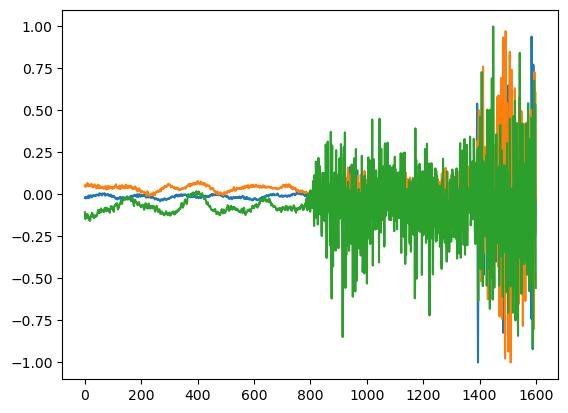

In [8]:
plt.plot(earthquake_data[0,:].T)

In [9]:
#np.save("IRIS_earthquake_waveforms.npy",earthquake_data)

# Non-Earthquake Signal

In [10]:
client = obspy.clients.fdsn.Client("IRIS")
starttime = "2010-10-31T00:00:00"
endtime = "2012-02-09T23:59:59"
st = obspy.UTCDateTime(starttime)
et = obspy.UTCDateTime(endtime)

noise = []
s=0
while(s<=500):    
    for j in range(len(df)):
        t = df['Origin Time (UTC)'][j].datetime.strftime("%Y-%m-%d %H:%M:%S")
        t1 = obspy.UTCDateTime(t)
        t2 = t1+40
        if st+40<t1:
            overlap=False
        elif st>t2:
            overlap=False
        else:
            overlap=True
            break
        
    if overlap==False:
        wavedata = client.get_waveforms(network="TA",
                            station = "V36A",
                            location = "--",
                            channel = "BH?",
                            starttime=st,
                            endtime=st+40,
                            )
        
        noise2 = np.zeros((3,1600))
        for j in range(3):
            if len(wavedata[j].data)<1600:
                p = list(wavedata[j].data/(abs(wavedata[j].data).max()))
                diff = 1600-len(wavedata[j].data)
                for ii in range(diff):
                    p.append(0)
                noise2[j] = np.array(p)
                
            elif len(wavedata[j].data)>1600:
                noise2[j] = wavedata[j].data[:1600]/(abs(wavedata[j].data[:1600]).max())
            
            else:
                noise2[j] = wavedata[j].data/(abs(wavedata[j].data).max())
                
        noise.append(noise2)
        s+=1
    
    if s%100==0: print("{} non-earthquake samples collected...".format(s))
    st = st+40

noise_data = np.array(noise)
print("Total no. of non-earthquake samples: ",noise_data.shape[0])

100 non-earthquake samples collected...
200 non-earthquake samples collected...
300 non-earthquake samples collected...
400 non-earthquake samples collected...
500 non-earthquake samples collected...
Total no. of non-earthquake samples:  501


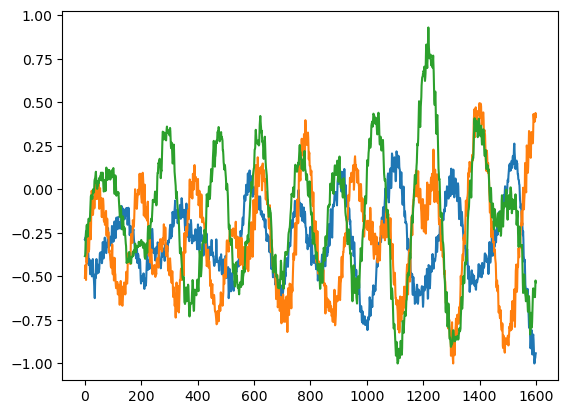

In [11]:
plt.plot(noise_data[200].T)

In [12]:
#np.save("IRIS_non_earthquake_waveforms.npy", noise_data)

In [14]:
y_earthquake_data = np.ones((len(df),1))
y_noise_data = np.zeros((len(noise_data),1))
W = np.concatenate([earthquake_data,noise_data], axis=0)
Y = np.concatenate([y_earthquake_data, y_noise_data], axis=0)
W.shape,Y.shape

((602, 3, 1600), (602, 1))

In [15]:
seed = 42
np.random.seed(seed)
np.random.shuffle(W)
np.random.seed(seed)
np.random.shuffle(Y)

In [16]:
Y

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

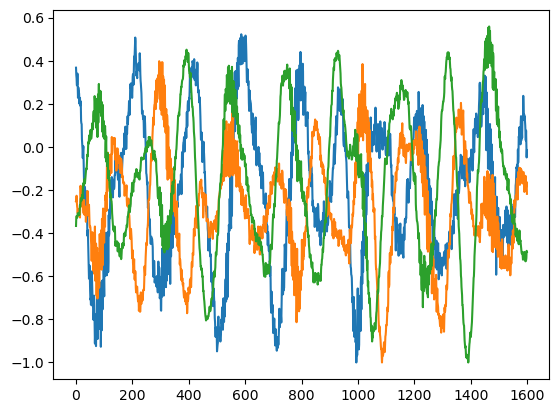

In [17]:
plt.plot(W[0].T)

In [18]:
np.max(earthquake_data), np.min(earthquake_data)

(1.0, -1.0)

In [19]:
np.max(noise_data), np.min(noise_data)

(1.0, -1.0)

In [20]:
W.shape

(602, 3, 1600)

In [27]:
np.save("IRIS_dataset_waveforms_train_602_samples.npy", W)
np.save("IRIS_dataset_label_train_602_samples.npy",Y)

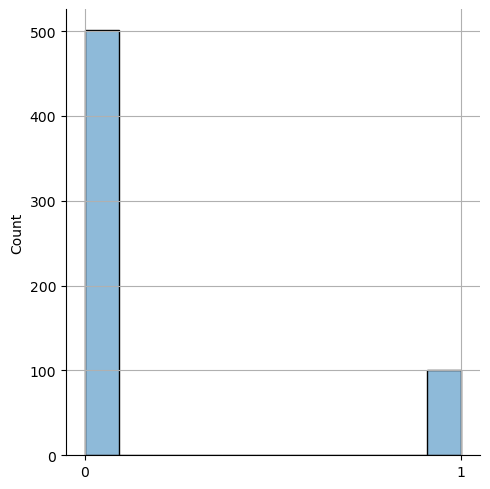

In [25]:
import seaborn as sns
sns.displot(Y,legend=False, kind='hist')
plt.xticks([0,1])
plt.grid()